In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
from copy import deepcopy

## Step 1
Import data and make some exploratory analysis. Distance is normalized to the average, Population is normalized to the total population

In [2]:
cities = pd.read_csv('cityData.dat', header=None, sep='\t', index_col=0, names=['City', 'Population', 'Latitude', 'Longitude'])
cities.head()

City  Population  Latitude  Longitude
0     Berlin    0.170716     52.52      13.38
1    Hamburg    0.087981     53.55      10.00
2     Munich    0.067102     48.14      11.58
3    Cologne    0.050797     50.95       6.97
4  Frankfurt    0.033703     50.12       8.68

In [3]:
cities.shape

(40, 4)

In [4]:
distances = pd.read_csv('cityDistances.dat', sep='\t', header= None, names=['Origin','Destiny','Distance'])
distances.head()

Origin  Destiny   Distance
0       0        1   5.084382
1       0        2  10.082311
2       0        3   9.523469
3       0        4   8.456714
4       0        5  10.201078

In [5]:
distances.shape

(780, 3)

### Step 1.5
Try to define a graph with the data 

In [6]:
Nodes = [(i,cities.to_dict(orient='records')[i]) for i in range(cities.shape[0])]
Edges = [(distances.iloc[i,0],distances.iloc[i,1],{'weight': distances.iloc[i,2]}) for i in range(distances.shape[0])]

In [7]:
print(Nodes[:3])
print(Edges[:3])

[(0, {'City': 'Berlin', 'Population': 0.1707159963294827, 'Latitude': 52.52, 'Longitude': 13.38}), (1, {'City': 'Hamburg', 'Population': 0.0879805435806981, 'Latitude': 53.55, 'Longitude': 10.0}), (2, {'City': 'Munich', 'Population': 0.0671020343799828, 'Latitude': 48.14, 'Longitude': 11.58})]
[(0, 1, {'weight': 5.084381891841052}), (0, 2, {'weight': 10.082311312508343}), (0, 3, {'weight': 9.523468735599538})]


In [8]:
## Possible useful lists for a general graph
# edges = list(graph.edges) # list of tuples
# nodes = list(graph.nodes) 
# weights = [graph.get_edge_data(i[0],i[1],default=0)['weight'] for i in edges]

In [9]:
# This is a preliminary complete graph
G = nx.Graph()
G.add_nodes_from(Nodes)
G.add_edges_from(Edges)

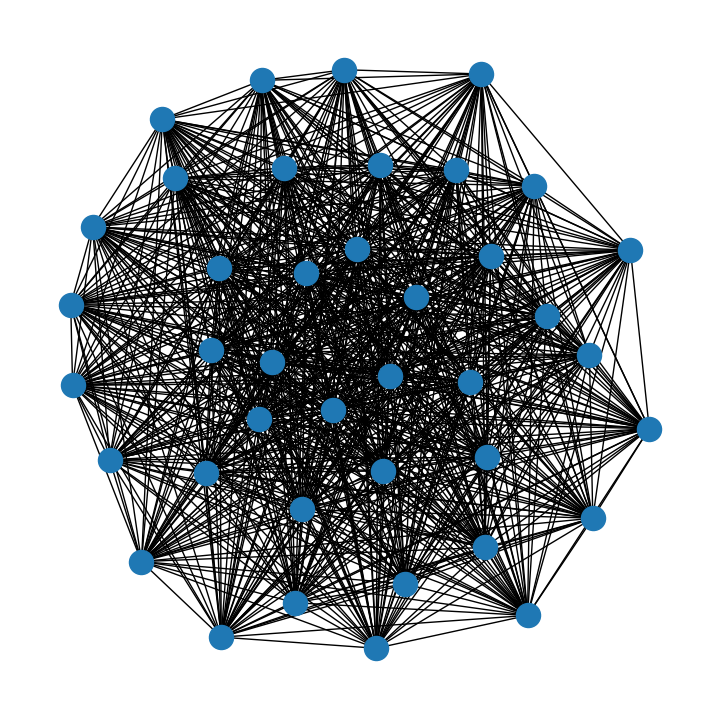

In [10]:
plt.figure(figsize=(7,7))
nx.draw(G)
plt.show()

In [22]:
# p = dict(nx.shortest_path_length(G, weight='weight'))
# [p[0][i] for i in range(cities.shape[0])]

# p = nx.shortest_path_length(G, source=0, target=13, weight='weight')
# p

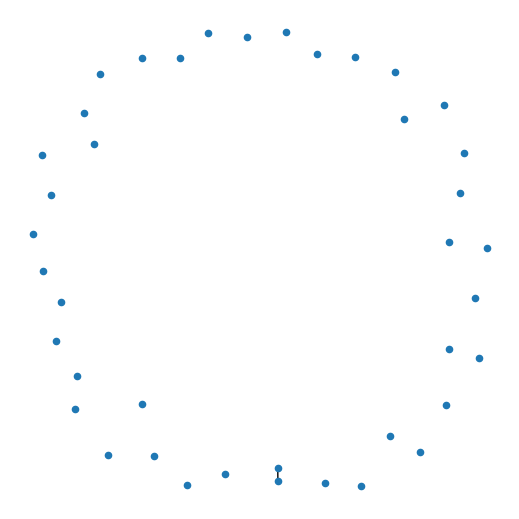

In [19]:
G0 = nx.Graph()
G0.add_nodes_from(Nodes)

G1 = G0.copy()
G1.add_edge(0,5,weight=1.2)

plt.figure(figsize=(5,5))
nx.draw(G1, node_size=20)
plt.show()

## Step 2
Define the cost functions
$$C_{tot} = C_{infra} + \gamma C_{trans}$$
$$C_{infra} = \sum_{e_{ij}\in E}d(e_{ij}) $$
$$C_{trans} = \frac{1}{2} \sum_{i,j \in V} P_i P_j ~ \tilde{d}_{ji} $$

Where $ \tilde{d}_{ji}$ is defined by

$$ \tilde{d}(e_{ij}) = (1-\delta) d(e_{ij}) + \delta $$

In [57]:
def C_infra(graph):
    num_nodes = len(graph.nodes)
    sum = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i==j:
                d_ij = 0
            elif (nx.has_path(graph,i,j)):
                d_ij = nx.shortest_path_length(graph, i, j, weight='weight')
            else: 
                d_ij = np.Inf
            sum += d_ij
    return 0.5*sum

In [58]:
C_infra(G)

4445.973500061165

In [44]:
def eff_len(graph, i, j, δ):
    d_ij = nx.shortest_path_length(graph, source=i, target=j, weight='weight') 
    return (1-δ)*d_ij + δ

In [42]:
eff_len(G, 0, 2, 0.33)

7.085148579380589

In [46]:
def C_trans(graph, δ, Pop=None):
    if Pop is None:
        Pop = nx.get_node_attributes(graph,name='Population') # dict with population of each node, for ex: {0: 0.234,...}

    num_nodes = len(graph.nodes)
    sum = 0
    for i in range(num_nodes):
        for j in range(num_nodes): 
            if graph.has_edge(i,j):
                sum += Pop[i]*Pop[j]*eff_len(graph, i, j, δ)
    return 0.5*sum

In [47]:
C_trans(G, delta)

2.1918727374227065

In [50]:
def C_tot(graph,γ,δ,Pop=None):
    if Pop is None:
        Pop = nx.get_node_attributes(graph,name='Population') # dict with population of each node, for ex: {0: 0.234,...}
    return C_infra(graph) + γ*C_trans(graph,δ,Pop)

In [51]:
delta= 0.33
gamma = 200

print(C_infra(G)) # This is going to be large, because G is a complete network
print(C_trans(G,delta))
print(C_trans(G,delta)*gamma)
print(C_tot(G,gamma,delta))

4445.973500061165
2.1918727374227065
438.3745474845413
4884.348047545706


## Step 3

Implement the Metropolis algorithm. Start with a complete graph and start removing edges to see if the cost function is reduced.

In [69]:
def Metropolis_step(graph, γ, δ, T=0):
    # num_nodes = len(graph.nodes)
    link = sample(list(graph.nodes),2)
    
    # Avoid selecting the same node twice
    while link[0] == link[1]:
        link = sample(list(graph.nodes),2)

    new_graph = graph.copy()   # This is inefficient, but good for v.1.
    if new_graph.has_edge(link[0],link[1]):
        new_graph.remove_edge(link[0],link[1])        
    
    old_cost = C_tot(graph,γ,δ)
    new_cost = C_tot(new_graph,γ,δ)
    if new_cost<old_cost:
        return new_graph
    else:
        return graph
    

In [70]:
Metropolis_step(G,gamma,delta)

In [71]:
G2 = G.copy()
for i in range(200):
    G2 = Metropolis_step(G2,gamma,delta)
    if i%20==0:
        print(i)

0
20
40
60
80
100
120
140
160
180


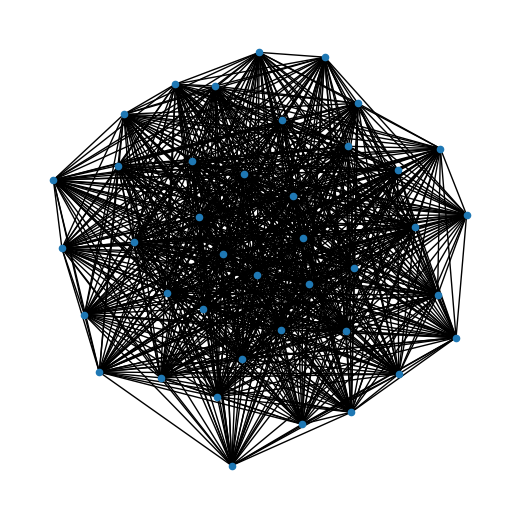

In [68]:
plt.figure(figsize=(5,5))
nx.draw(G2, node_size=20)
plt.show()